In [32]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import librosa
import soundfile as sf

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [ ]:
AUDIO_DIR = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\joao\data\task1\training\phonationA'
LABELS_PATH = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\joao\data\task1\labels.csv'
SAMPLE_RATE = 8000   # Taxa de amostragem dos áudios
N_MFCC = 13          # Número de coeficientes MFCCs
LATENT_DIM = 20      # Dimensões do espaço latente
BATCH_SIZE = 64      # Tamanho do lote
N_EPOCHS = 2000      # Número de épocas

### Curiosidades

<b>MFCC</b>

No processamento de áudio, o cepstro de frequência Mel (MFC) é uma representação do espectro de potência de curto prazo de um som, obtida a partir de uma transformação discreta do espectro de potência logarítmico, mapeado em uma escala Mel, que é uma escala de frequência não linear inspirada na percepção auditiva humana.

Os coeficientes cepstrais de frequência Mel (MFCCs) são os valores que, em conjunto, formam um MFC. Eles são derivados de uma representação cepstral do áudio — ou seja, do “espectro do espectro” de forma não linear. A principal diferença entre o cepstro tradicional e o cepstro de frequência Mel é que, no MFC, as bandas de frequência são distribuídas de forma uniforme na escala Mel, aproximando-se mais da forma como o ouvido humano percebe o som, ao invés do espaçamento linear das frequências no espectro convencional. Essa adaptação melhora a representação do som, sendo especialmente útil em aplicações como compressão de áudio, reconhecimento de fala e análise acústica, reduzindo a largura de banda necessária e melhorando a eficiência do processamento.

O cálculo dos MFCCs geralmente segue os seguintes passos:

- Janela temporal e Transformada de Fourier (FFT): O sinal de áudio é dividido em trechos curtos (janelas), e para cada trecho é calculada a transformada de Fourier, obtendo-se o espectro de potência.

- Mapeamento na escala Mel: As potências do espectro são projetadas na escala Mel, utilizando bancos de filtros triangulares sobrepostos ou, alternativamente, janelas cosseno sobrepostas.

- Logaritmo das potências: Calcula-se o logaritmo das potências em cada faixa de frequência Mel, aproximando a percepção humana de intensidade sonora.

- Transformada Discreta de Cosseno (DCT): Aplica-se a DCT sobre a lista de potências logaritmizadas, obtendo um espectro que representa a envoltória do espectro original.

- Os MFCCs correspondem às amplitudes do espectro resultante e formam a base de muitas técnicas de análise de áudio e reconhecimento de padrões acústicos.

<b>BATCH SIZE</b>

O `batch size` é um dos hiperparâmetros mais importantes no treinamento de redes neurais.

Durante o treinamento, sua rede não atualiza os pesos após ver cada exemplo individualmente, nem espera ver todos os exemplos do dataset de uma vez só, pois isso seria muito pesado para processar. Em vez disso, o conjunto de dados é dividido em pequenos lotes, e a rede:

- Faz uma passagem direta (forward) com todos os exemplos do lote.
- Calcula a média do erro (loss) do lote.
- Faz uma passagem reversa (backpropagation) para atualizar os pesos com base nesse erro médio.

Suponha que você tenha 1.600 áudios e define: BATCH_SIZE = 16

O modelo vai dividir o dataset em:

1600/16 = 100 batches por época

Cada batch contém 16 exemplos, e a cada lote processado o modelo ajusta os pesos uma vez.

| Tamanho do Batch	        | Características |
| ------------------------- | --------------- |
| Pequeno (ex: 8, 16)	    | Atualizações mais frequentes → aprendizado mais “instável” mas às vezes melhor generalização        |
| Grande (ex: 64, 128, 256) | Atualizações mais suaves e estáveis, mas requer mais memória e pode “ficar preso” em mínimos locais |

## 1. Extração de Características (MFCCs)

In [ ]:
class AudioFeatureDataset(Dataset):
    def __init__(self, audio_files, csv_path, sample_rate=8000, n_mfcc=13, scaler=None):
        self.audio_files = audio_files
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.scaler = scaler

        self.df_labels = pd.read_csv(csv_path)
        self.id_to_class = {row['ID']: int(row['Class']) for _, row in self.df_labels.iterrows()}

        self.features = []
        self.classes = []

        all_features = []

        for file in self.audio_files:
            mfccs = self.extract_mfcc(file)
            if mfccs is not None:
                self.features.append(mfccs)
                all_features.append(mfccs)

                file_id = os.path.basename(file).split('_')[0]
                if file_id not in self.id_to_class:
                    raise ValueError(f"ID {file_id} não encontrado no CSV")
                self.classes.append(self.id_to_class[file_id])

        if self.scaler is None:
            all_frames = np.concatenate(all_features, axis=0)
            self.scaler = StandardScaler()
            self.scaler.fit(all_frames)
            print("Scaler ajustado com sucesso.")

        self.normalized_features = [
            torch.tensor(self.scaler.transform(f), dtype=torch.float32)
            for f in self.features
        ]

        print(f"Total de {len(self.normalized_features)} áudios carregados e normalizados.")

    def extract_mfcc(self, file_path):
        try:
            audio, sr = librosa.load(file_path, sr=self.sample_rate)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=self.n_mfcc)
            return mfccs.T
        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")
            return None

    def __len__(self):
        return len(self.normalized_features)

    def __getitem__(self, idx):
        features = self.normalized_features[idx]
        length = features.shape[0]
        classe = self.classes[idx]
        return features, length, classe

def collate_fn(batch):
    sequences, lengths, classes = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long)
    padded_batch = pad_sequence(sequences, batch_first=True)
    
    lengths, sorted_idx = lengths.sort(descending=True)
    padded_batch = padded_batch[sorted_idx]
    classes = torch.tensor([classes[i] for i in sorted_idx], dtype=torch.long)

    return padded_batch, lengths, classes

## 2. Autoencoder LSTM para Sequências

In [ ]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.encoder_linear = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder_linear = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_linear = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, lengths):
        batch_size, max_len, _ = x.size()
        
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True)
        
        _, (h_n, c_n) = self.encoder_lstm(packed_input)
        z = self.encoder_linear(h_n[-1])
        
        h_0_decoder = self.decoder_linear(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c_0_decoder = torch.zeros_like(h_0_decoder)
        
        packed_input_decoder = pack_padded_sequence(x, lengths.cpu(), batch_first=True)
        packed_output, _ = self.decoder_lstm(packed_input_decoder, (h_0_decoder, c_0_decoder))
        
        output, _ = pad_packed_sequence(packed_output, batch_first=True, total_length=max_len)
        x_recon = self.output_linear(output)
        
        return x_recon, z

## 3. Treinamento

In [ ]:
all_audio_files = glob.glob(os.path.join(AUDIO_DIR, "*.wav"))

if not all_audio_files:
    print(f"Nenhum arquivo de áudio encontrado em {AUDIO_DIR}. Verifique o caminho e a extensão.")
else:
    print(f"Encontrados {len(all_audio_files)} arquivos de áudio.")
    
    dataset = AudioFeatureDataset(all_audio_files, csv_path=LABELS_PATH)
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMAutoencoder(input_dim=N_MFCC, hidden_dim=64, latent_dim=LATENT_DIM).to(device)
    criterion = nn.MSELoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    loss_history = []
    print("Iniciando treinamento...")
    for epoch in range(N_EPOCHS):
        total_loss = 0
        for batch, lengths, classes in dataloader:
            batch = batch.to(device)
            
            optimizer.zero_grad()
            recon, z = model(batch, lengths)
            
            mask = torch.zeros_like(batch, dtype=torch.bool).to(device)
            for i, l in enumerate(lengths):
                mask[i, :l, :] = True
            
            loss_all = criterion(recon, batch)
            loss_masked = loss_all * mask.float()
            loss = loss_masked.sum() / mask.sum()
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * lengths.size(0)
        
        avg_loss = total_loss / len(dataset)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{N_EPOCHS} | Loss: {avg_loss:.6f}")
                
    print("Treinamento concluído.")

Encontrados 272 arquivos de áudio.
Scaler ajustado com sucesso.
Total de 272 áudios carregados e normalizados.
Iniciando treinamento...
Epoch 1/2000 | Loss: 0.991394
Epoch 2/2000 | Loss: 0.941259
Epoch 3/2000 | Loss: 0.894614
Epoch 4/2000 | Loss: 0.839619
Epoch 5/2000 | Loss: 0.784931
Epoch 6/2000 | Loss: 0.723285
Epoch 7/2000 | Loss: 0.649930
Epoch 8/2000 | Loss: 0.574639
Epoch 9/2000 | Loss: 0.505676
Epoch 10/2000 | Loss: 0.448742
Epoch 11/2000 | Loss: 0.397385
Epoch 12/2000 | Loss: 0.357239
Epoch 13/2000 | Loss: 0.326281
Epoch 14/2000 | Loss: 0.295465
Epoch 15/2000 | Loss: 0.270153
Epoch 16/2000 | Loss: 0.242950
Epoch 17/2000 | Loss: 0.221101
Epoch 18/2000 | Loss: 0.200323
Epoch 19/2000 | Loss: 0.182590
Epoch 20/2000 | Loss: 0.166912
Epoch 21/2000 | Loss: 0.151449
Epoch 22/2000 | Loss: 0.138398
Epoch 23/2000 | Loss: 0.125689
Epoch 24/2000 | Loss: 0.114455
Epoch 25/2000 | Loss: 0.104237
Epoch 26/2000 | Loss: 0.095793
Epoch 27/2000 | Loss: 0.088072
Epoch 28/2000 | Loss: 0.081811
Epoch

### Loss VS Epoch

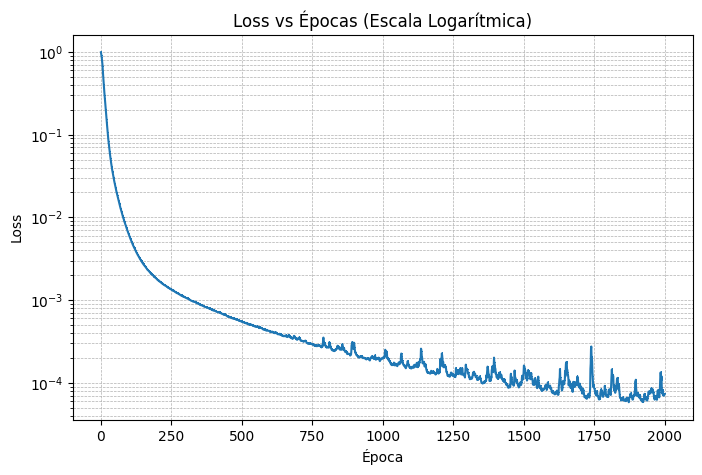

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, N_EPOCHS+1), loss_history, marker=',')
plt.title("Loss vs Epoch")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Espaço latente (3D)

Extraindo vetores latentes...
latent_vectors shape (antes de concatenar): []
classes shape (antes de concatenar): []
Exemplo de classes: vazio


C:\Users\joaov_zm1q2wh\AppData\Local\Temp\ipykernel_19684\673750162.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_classes))            # Usar um colormap mais robusto como 'tab10' para classes discretas


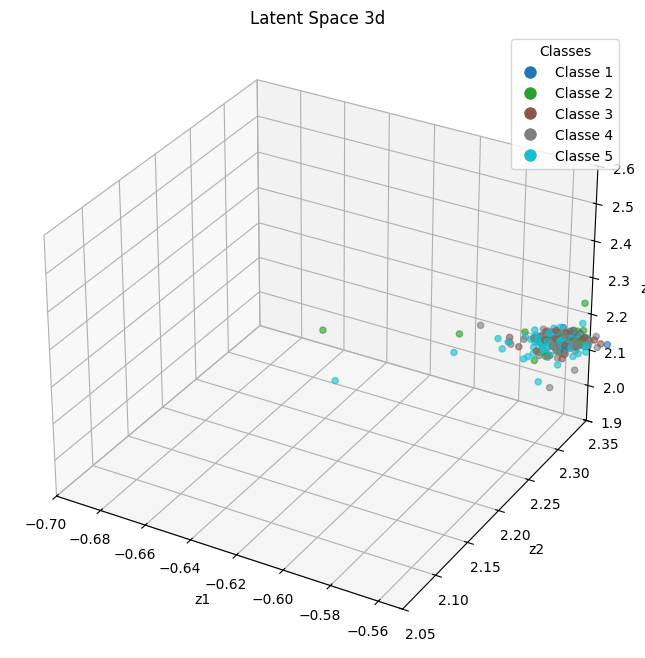

Plotagem concluída. Total de 272 vetores latentes extraídos.


In [ ]:
if 'model' in locals() and LATENT_DIM in [2, 3]:
    print("Extraindo vetores latentes...")
    
    model.eval()
    latent_vectors = []
    all_classes = []
    
    with torch.no_grad():
        print("latent_vectors shape (antes de concatenar):", [v.shape for v in latent_vectors])
        print("classes shape (antes de concatenar):", [c.shape for c in all_classes])
        print("Exemplo de classes:", all_classes[0] if all_classes else "vazio")
        
        for batch, lengths, classes in dataloader:
            batch = batch.to(device)
            _, z = model(batch, lengths)
            latent_vectors.append(z.cpu().numpy())
            all_classes.append(classes.cpu().numpy())
            
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    all_classes = np.concatenate(all_classes, axis=0)
    
    
    unique_classes = np.unique(all_classes)
    cmap = plt.cm.get_cmap('tab10', len(unique_classes))
    class_to_idx = {cls: i for i, cls in enumerate(unique_classes)}
    colors = [cmap(class_to_idx[cls]) for cls in all_classes]
        
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], latent_vectors[:, 2], c=colors, alpha=0.6)
    
    ax.set_xlim([-0.7, -0.55])
    ax.set_ylim([2.05, 2.35])
    ax.set_zlim([1.9, 2.6])

    ax.set_title('Latent Space 3d')
    ax.set_xlabel('z1')
    ax.set_ylabel('z2')
    ax.set_zlabel('z3')
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(class_to_idx[cls]), markersize=10, label=f'Classe {cls}') for cls in unique_classes]
    ax.legend(handles=handles, title="Classes")
    plt.show()
        
    print(f'Plotagem concluída. Total de {len(latent_vectors)} vetores latentes extraídos.')
else:
    print('Plotagem do espaço latente não realizada.')